In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
yf_data = yf.download('F', start="1800-01-01")
yf_data.reset_index(inplace=True)
yf_data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.226079,1091238
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.225653,1174468
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.225653,5209582
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.223099,1424158
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.221821,675088


In [ ]:
# Daily returns calculations 
data = yf_data[["Date", "Adj Close"]]
data.set_index("Date", inplace=True)
data = data.rename(columns={"Adj Close": "Ford stock price"})
data["Daily returns"] = data["Ford stock price"].pct_change()*100
data = data.loc[data["Daily returns"] != 0]

# Volatility calculations 
rolling_window = 20
data["Rolling Mean"] = data["Daily returns"].rolling(window=rolling_window).mean()
data["Rolling Variance"] = data["Daily returns"].rolling(window=rolling_window).apply(
    lambda x: ((x - x.mean()) ** 2).sum() / (len(x) - 1), raw=True
)
data["Volatility"] = data["Rolling Variance"] ** 0.5
data.drop(columns=["Rolling Mean", "Rolling Variance"], inplace=True)

# Drop NA rows
data.dropna(axis=0, how="any", inplace=True)

data

,Ford stock price,Daily returns,Volatility
Date,,,
1972-07-03,0.216712,-0.391371,0.665883
1972-07-05,0.215435,-0.589419,0.671238
1972-07-06,0.217990,1.185792,0.706339
1972-07-07,0.217138,-0.390600,0.701270
1972-07-10,0.214583,-1.176553,0.727105
...,...,...,...
2024-11-11,11.230000,2.370094,2.742602
2024-11-12,11.100000,-1.157606,2.752199
2024-11-14,11.070000,-0.270276,2.730101


Text(0, 0.5, 'Ford stock price')

<Figure size 1200x600 with 0 Axes>

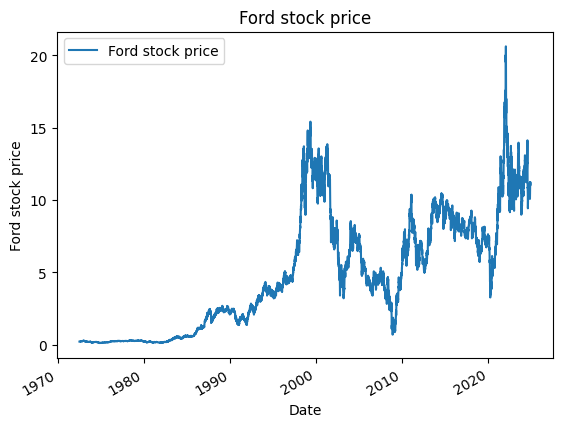

In [20]:
plt.figure(figsize=(12, 6))
data.plot(y='Ford stock price', title='Ford stock price')
plt.xlabel('Date')
plt.ylabel('Ford stock price')

In [23]:
print(f"Mean daily return is {round(data['Daily returns'].mean(), 5)}%")
print(f"Mean volatility over stock returns is {round(data['Volatility'].mean(), 5)}")

print(f"\nAnnualized mean daily return is {round(data['Daily returns'].mean(), 5)*252}%")
print(f"Annualized mean volatility over stock returns is {round(data['Volatility'].mean(), 5)*252}")

Mean daily return is 0.05823%
Mean volatility over stock returns is 2.05044

Annualized mean daily return is 14.67396%
Annualized mean volatility over stock returns is 516.71088
